In [266]:
from pandas import read_csv
import datetime
from pandas import Series, DataFrame

dataset = read_csv('2019-06-13-Comments Before 2019-04-04-randomized.csv')
dataset.head()

,id,product_id,user_id,purchased_variant_id,title,comment,advantages,disadvantages,created_at,verification_status
0,318109559,19118836,37083487,57919781.0,عالی,عالی,NaN,NaN,2019-04-04 21:19:04,verified
1,231829415,1385206,102574956,49696397.0,محافظ دسته,این که قبل عید سی تومن بود الان زده شصت تومن ا...,"[\""خوش دست و زیبا\""]","[\""قیمت بالا\""]",2019-04-04 21:18:08,rejected
2,381611181,14182432,307517,47989652.0,نوع جلد و نظر درباره کتاب,جلد کتاب سخت بود و در سایت نوشته نشده بود.\nبه...,NaN,"[\""جلد سخت کتاب\\r\"",\""قیمت کمی بالاتر از انتظ...",2019-04-04 21:18:00,verified
3,93129005,15816336,130110910,NaN,خوب بود,خیلی خوب بود ولی بنظرم نسبت به رنگارنگ قیمت تف...,"[\""راحتی و بیس مناسب\""]","[\""گران بود نسبت به رنگ ها \""]",2019-04-04 21:17:56,verified
4,337837724,17810598,143426093,30317751.0,خوب نیست نخرید,برا آقایون اصلا خوب نیست بعد از سه هفته استفاد...,NaN,NaN,2019-04-04 21:17:38,rejected


In [267]:
from __future__ import unicode_literals
from hazm import *
import itertools

def Hanieh_Preprocess(doc):
    #Normalization
    FA_NUM= ['۰','۱','۲','۳','۴','۵','۶','۷','۸','۹']
    AR_NUM= ['٠','١','٢','٣','٤','٥','٦','٧','٨','٩']
    EN_NUM= ['0','1','2','3','4','5','6','7','8','9']
    FA_char = ['ا','ب','م','ر','ی','س','ه','ک','ن','د']
    ALEF = '\u0627';
    ALEF_MADDA = '\u0622';
    ALEF_HAMZA_ABOVE = '\u0623';
    ALEF_HAMZA_BELOW = '\u0625';

    WAW = '\u0648';
    WAW_HAMZA_ABOVE = '\u0624';

    YEH = '\u064A';
    YEH_HAMZA_ABOVE = '\u0626';
    FARSI_YEH = '\u06CC';

    KAF = '\u0643';
    KEHEH = '\u06A9';

    HEH = '\u0647';
    HEH_HAMZA_ABOVE = '\u06C2';
    TEH_MARBUTA = '\u0629';


    #Removing these chars
    KASHIDA = '\u0640';
    HAMZA = '\u0621';
    FATHATAN = '\u064B';
    DAMMATAN = '\u064C';
    KASRATAN = '\u064D';
    FATHA = '\u064E';
    DAMMA = '\u064F';
    KASRA = '\u0650';
    SHADDA = '\u0651';
    SUKUN = '\u0652';
    for i in EN_NUM:
        index = EN_NUM.index(i)
        doc = doc.str.replace(i,FA_NUM[index])
    for i in AR_NUM:
        index = AR_NUM.index(i)
        doc = doc.str.replace(i,FA_NUM[index])

    for i in [KASHIDA, HAMZA, FATHATAN, DAMMATAN, KASRATAN, FATHA, DAMMA, KASRA, SHADDA, SUKUN]:
        doc = doc.str.replace(i, '')

        doc = doc.str.replace(ALEF_HAMZA_ABOVE, ALEF)
        doc = doc.str.replace(ALEF_HAMZA_BELOW, ALEF)
        doc = doc.str.replace(ALEF_MADDA, ALEF)

        doc = doc.str.replace(WAW_HAMZA_ABOVE, WAW)

        doc = doc.str.replace(YEH, FARSI_YEH)
        doc = doc.str.replace(YEH_HAMZA_ABOVE, FARSI_YEH)

        doc = doc.str.replace(KAF, KEHEH)

        doc = doc.str.replace(HEH_HAMZA_ABOVE, HEH)
        doc = doc.str.replace(TEH_MARBUTA, HEH)
        
    return doc

def Hazm_Preprocess(doc):
    
    normalizer = Normalizer()
    stemmer = Stemmer()
    lemmatizer = Lemmatizer()
    stopwords = stopwords_list()
    for comment in doc:
        words = [word_tokenize(sentence) for sentence in sent_tokenize(normalizer.normalize(str(comment)))]
        comment = [lemmatizer.lemmatize(stemmer.stem(word)) 
                   for word in list(itertools.chain.from_iterable(words)) if not word in stopwords]
        
    return doc

In [268]:
import pandas as pd

dataset.comment = Hanieh_Preprocess(dataset.comment)
dataset.comment = Hazm_Preprocess(dataset.comment)

df = pd.DataFrame(dataset[['comment', 'verification_status']]).dropna()
df = pd.DataFrame(df.comment.str.split().tolist(), index=df.verification_status).stack()
df = df.reset_index([0, 'verification_status'])
df.columns = ['verification_status','word']

df.head()

,verification_status,word
0,verified,عالی
1,rejected,این
2,rejected,که
3,rejected,قبل
4,rejected,عید


In [269]:
old_df = df.groupby(df.columns.tolist()).size().reset_index().\
rename(columns={0:'status_records'})
old_df = old_df.sort_values('verification_status', ascending=True)
old_df = old_df.drop_duplicates(subset='word', keep="first")

new_df = df.groupby(df.word.tolist()).size().reset_index().\
rename(columns={0:'total_records'})
new_df.columns = ['word','total_records']

last_df = pd.merge(old_df, new_df, left_on='word', right_on='word', how='left')

last_df.loc[last_df.verification_status=="rejected",'rejected/total']=(last_df.status_records/last_df.total_records)
last_df.loc[last_df.verification_status=="verified",'rejected/total']=(1-last_df.status_records/last_df.total_records)
last_df = last_df.drop(['verification_status','status_records'], axis=1)

last_df.head()

,word,total_records,rejected/total
0,!,513,0.454191
1,میکردید.,4,0.500000
2,میکردید????,1,1.000000
3,میکردید،با,1,1.000000
4,میکردید؟,1,1.000000


In [270]:
import pandas as pd
pd.options.mode.chained_assignment = None

HighProb_df = last_df.loc[((last_df['rejected/total'] > 0.9)|(last_df['rejected/total'] < 0.1)) & (last_df['total_records']>10)]
HighProb_df.loc[(HighProb_df['rejected/total'] < 0.1),'HighProb_status']='verified'
HighProb_df.loc[(HighProb_df['rejected/total'] > 0.9),'HighProb_status']='rejected'
HighProb_df.to_csv('HighProb.csv',index=False)

MostRejected_df = HighProb_df.loc[HighProb_df.HighProb_status=='rejected']
MostAccepted_df = HighProb_df.loc[HighProb_df.HighProb_status=='verified']

MRwords = MostRejected_df.word.tolist()
MAwords = MostAccepted_df.word.tolist()

dataset['HighProb_status']='no status'
for word in MAwords:
    dataset.loc[dataset.comment.str.find(word) != -1 , 'HighProb_status'] = 'verified'
for word in MRwords:
    dataset.loc[dataset.comment.str.find(word) != -1 , 'HighProb_status'] = 'rejected'
    
dataset.head()
dataset.to_csv('Dataset.csv',index=False)

In [271]:
print("Number of verified status= "+str(int(sum(dataset.HighProb_status=='verified'))))
print("Number of correct verified status= "+str(sum((dataset.verification_status==dataset.HighProb_status) & (dataset.HighProb_status=='verified'))))
print("Number of rejected status= "+str(int(sum(dataset.HighProb_status=='rejected'))))
print("Number of correct rejected status= "+str(int(sum((dataset.verification_status==dataset.HighProb_status) & (dataset.HighProb_status=='rejected')))))

NumOfCoverdComm=sum(dataset.HighProb_status!='no status')
print("Number of correct verifications="+str(sum(dataset.verification_status==dataset.HighProb_status)))
print("Number of coverd comments to total= "+str(NumOfCoverdComm)+" to "+str(len(dataset.index)))

Number of verified status= 40359
Number of correct verified status= 33746
Number of rejected status= 14898
Number of correct rejected status= 11052
Number of correct verifications=44798
Number of coverd comments to total= 55257 to 100000


test score: 1.0
train score: 0.7480759363776296
Mean Absolute Error (MAE): 0.23963133640552994
Mean Squared Error (MSE): 0.23963133640552994
Root Mean Squared Error (RMSE): 0.48952153824477423
Naive Bayes model Error Rate: 0.23963133640552992


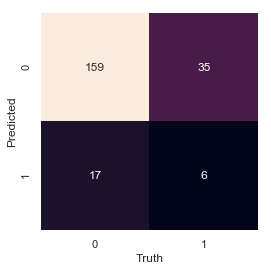

(array([ 17.,   0.,   0.,   0.,   0., 165.,   0.,   0.,   0.,  35.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

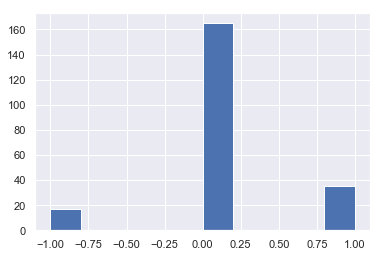

In [272]:
filtered_df = last_df[last_df['total_records']>=100]
filtered_df = filtered_df.reset_index([0])

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.pyplot as plt
import numpy as np
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.metrics import zero_one_loss
import seaborn as sns; sns.set()
from sklearn.naive_bayes import GaussianNB

X = filtered_df['total_records'].values.reshape(-1,1)
y = (filtered_df['rejected/total']>=0.44).astype('int')

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=1000)

#train_X = filtered_df[(filtered_df['rejected/total'] >= 0.9) | (filtered_df['rejected/total'] <= 0.1)]['total_records'].values.reshape(-1,1)
#train_y = (filtered_df[(filtered_df['rejected/total'] >= 0.9) | (filtered_df['rejected/total'] <= 0.1)]['rejected/total'] >= 0.5).astype(int)
#test_X = filtered_df[(filtered_df['rejected/total'] < 0.9) & (filtered_df['rejected/total'] > 0.1)]['total_records'].values.reshape(-1,1)
#test_y = (filtered_df[(filtered_df['rejected/total'] < 0.9) & (filtered_df['rejected/total'] > 0.1)]['rejected/total']>=0.5).astype(int)
#model = LogisticRegression(); 
#result = model.fit(train_X, train_y);

model = GaussianNB()
model.fit(train_X, train_y);
p_pred = model.predict_proba(test_X)
y_pred = model.predict(test_X)

print("test score: "+str(model.score(test_X, y_pred)))
print("train score: "+str(model.score(train_X, train_y)))


print("Mean Absolute Error (MAE): "+str(metrics.mean_absolute_error(test_y, y_pred)))
print("Mean Squared Error (MSE): "+str(metrics.mean_squared_error(test_y, y_pred)))
print("Root Mean Squared Error (RMSE): "+str(np.sqrt(metrics.mean_squared_error(test_y, y_pred))))

print("Naive Bayes model Error Rate: "+str(zero_one_loss(test_y, y_pred, normalize=True)))
mat = confusion_matrix(y_pred, test_y)
names = np.unique(y_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=names, yticklabels=names)
plt.xlabel('Truth')
plt.ylabel('Predicted')
plt.show()
#display(plt.scatter(test_y, y_pred))
display(plt.hist(test_y - y_pred))

filtered_df['predicted_status']=model.predict(X)
filtered_df.loc[filtered_df.predicted_status==0,'predicted_status']='verified'
filtered_df.loc[filtered_df.predicted_status==1,'predicted_status']='rejected'

filtered_df.to_csv('Filtered_df.csv',index=False)

In [273]:
NumVer=0;NumRej=0;CrVer=0;CrRej=0
dataset['predicted_status']='no status'
for x in range(3):
    words = filtered_df.sample(frac=1).word.tolist()
    for word in words:
        if(str(filtered_df[filtered_df['word']==word].predicted_status).find('verified') != -1):
            dataset.loc[dataset.comment.str.find(word) != -1 , 'predicted_status'] = 'verified'
        elif(str(filtered_df[filtered_df['word']==word].predicted_status).find('rejected') != -1):
            dataset.loc[dataset.comment.str.find(word) != -1 , 'predicted_status'] = 'rejected'

    NumVer += sum(dataset.predicted_status=='verified')
    NumRej += sum(dataset.predicted_status=='rejected')
    CrVer += sum((dataset.verification_status==dataset.predicted_status) & (dataset.predicted_status=='verified'))
    CrRej += sum((dataset.verification_status==dataset.predicted_status) & (dataset.predicted_status=='rejected'))

In [274]:
print("Number of verified status= "+str(int(NumVer/3)))
print("Number of correct verified status= "+str(int(CrVer/3)))
print("Number of rejected status= "+str(int(NumRej/3)))
print("Number of correct rejected status= "+str(int(CrRej/3)))
NumOfCoverdComm = sum(dataset.predicted_status!=('no status'))
print("Number of coverd comments to total= "+str(NumOfCoverdComm)+" to "+str(len(dataset.index)))

dataset.to_csv('Dataset.csv',index=False)

Number of verified status= 96799
Number of correct verified status= 69045
Number of rejected status= 3038
Number of correct rejected status= 964
Number of coverd comments to total= 99838 to 100000
